# <mark>PyTorch:</mark> Stochastic-Gradient-Aggregation Dataset Imagewoof

In [1]:
# PyTorch Utils
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.utils.data import DataLoader, Subset
from torchvision.transforms import v2 as T
from torchvision import datasets
from torch.optim import lr_scheduler

# MatPlot
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# NumPy
import numpy as np

# Pandas
import pandas as pd

# Other Utils
import os
import datetime
from PIL import Image

In [2]:
# Debug CUDA information
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1650


In [3]:
# Device usage definition
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

### Functions For Later Use

In [4]:
def process_image(img, transpose=False, numpy=False):
    """
    Preprocess the images to displays them in a plot.

    Parameters:
    - img: The image to preprocess.
    - transpose: Bool value if the img needs to be transposed.
    - numpy: Flag to identify if the image is already in a numpy array.

    Returns:
    - img: The image preprocessed.       
    """        
    if transpose:
        if numpy is False:
            img = img.numpy()
        img = img.transpose((1, 2, 0)) # Transform (X, Y, Z) shape
    img = (img - img.min()) / (img.max() - img.min()) # Clip the image to [0, 255] values
    return img

In [5]:
def preimage(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image

In [6]:
def obj_variance(obj, type=None):
    """
    Display the maximum and minimum value in a given object.

    Parameters:
    - obj: A given object.
    - type: Object type. Can be "tensor" and "numpy".
    """

    if type == "tensor":
        tensor_min = torch.min(obj)
        tensor_max = torch.max(obj)
        
        print("Maximum value:", "{:.2f}".format(tensor_max.item()))
        print("Minimum value:", "{:.2f}".format(tensor_min.item()))
    else:
        numpy_min = "{:.2f}".format(np.max(obj))
        numpy_max = "{:.2f}".format(np.min(obj))
        
        print("Maximum value:", numpy_max)
        print("Minimum value:", numpy_min)

In [7]:
def is_equal(obj1, obj2):
    """
    It compares two Numpy objects and check if they are equal or not.

    Parameters:
    - obj1: A given Numpy object.
    - obj2: A given Numpy object.
    """
    
    np_equal = np.array_equal(obj1, obj2)
    print("Are the images equal?", np_equal)

### Load Imagewoof Dataset

The images are 320x320, with pixel values ranging from 0 to 255. The labels are an array of strings, ranging from 0 to 9. These correspond to the class of clothing the image represents:

| <div style="width:300px">**Label**</div> |  <div style="width:300px">**Class**</div>  |
|:---------------|:---------------|
| n02086240      | Shih-Tzu |
| n02087394      | Rhodesian ridgeback |
| n02088364      | Beagle |
| n02089973      | English foxhound |
| n02093754      | Border terrier |
| n02096294      | Australian terrier |
| n02099601      | Golden retriever |
| n02105641      | Old English sheepdog |
| n02111889      | Samoyed |
| n02115641      | Dingo |

<br>

In [8]:
# Define the batch size
batch_size = 8

In [9]:
# Define the directory where your dataset is located
data_dir = 'Datasets/Imagewoof'

In [10]:
# Define the transformations you want to apply to the images
data_transforms = {
    'train': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.RandomHorizontalFlip(),
        T.RandomGrayscale(p=0.1),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.CenterCrop(224),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
# Create datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [12]:
# Create dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

### Define New Classes With the Correct Dog Breeds

In [13]:
# Correct dog breeds
dog_breeds = [
    'Shih-Tzu', 'Rhodesian Ridgeback', 'Beagle', 'English Foxhound', 'Border Terrier',
    'Australian Terrier', 'Golden Retriever', 'Old English Sheepdog', 'Samoyed', 'Dingo'
]

# Assing the dog breeds to the class names
class_names = dog_breeds

### Iterating and Visualising the Dataset

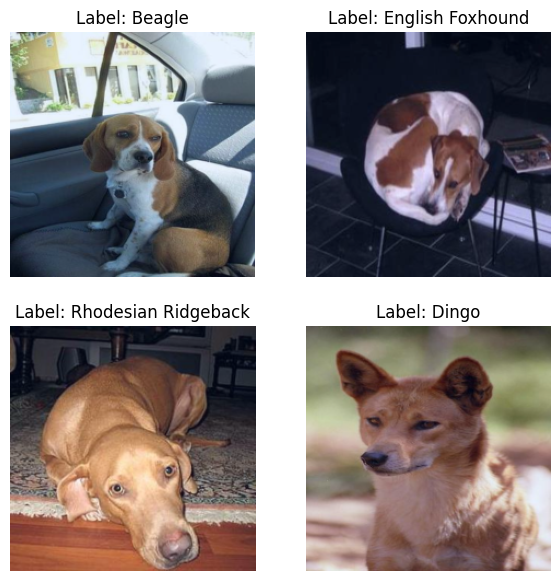

In [14]:
# Get a batch of images and labels
imgs, labels = next(iter(dataloaders['train']))

# Plot the images
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for i, ax in enumerate(axes.flat):
    # Convert the tensor to numpy array and transpose the dimensions if necessary
    img_np = imgs[i].numpy().transpose((1, 2, 0)) if isinstance(imgs, torch.Tensor) else imgs[i]
    img_np = process_image(img_np)
    
    ax.imshow(img_np)
    ax.set_title(f'Label: {class_names[labels[i]]}')
    ax.axis('off')

plt.show()

### Adversarial Dataset Development

In [15]:
uap = torch.load('./SGA/UAP/SGA/Delta_5000_20_Epochs_8_Batch.pth')

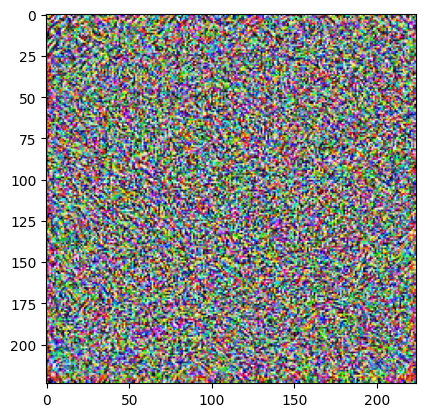

In [16]:
uap_processed = process_image(uap, transpose=True, numpy=False)
plt.imshow(uap_processed)

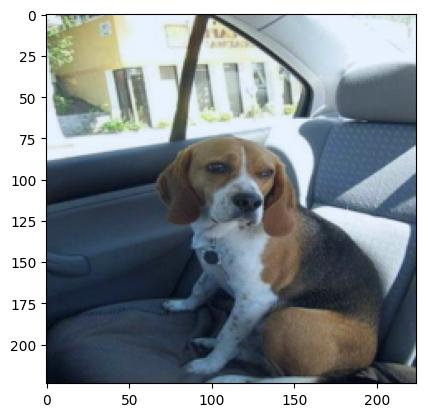

In [17]:
img = process_image(imgs[0], transpose=True, numpy=False)
plt.imshow(img)

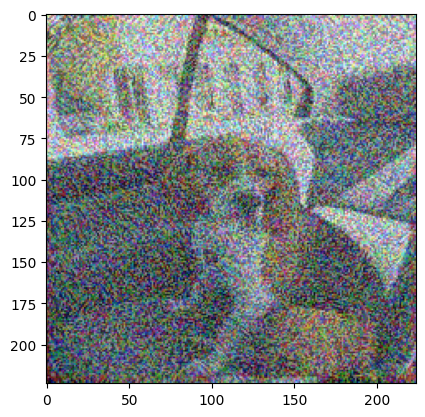

In [18]:
k = img + uap_processed
k_processed = process_image(k, transpose=False, numpy=True)
plt.imshow(k_processed)
plt.imsave(f"./Adversarial-Images/TestUAP.jpg", k_processed)

In [19]:
# Create an empty list to store adversarial images
adversarial_dataset = []
real_dataset = []
real_labels = []

for i in range(3):
    # Load your dataset
    imgs, labels = next(iter(dataloaders['val']))
    
    # Convert PyTorch tensor to numpy array if necessary
    imgs_np = imgs.numpy()
    labels_np = labels.numpy()
    
    uap = uap.cpu()
    
    # Iterate through the dataset
    for img in imgs_np:
        adversarial_img = img + uap.numpy()
        adversarial_dataset.append(adversarial_img)
        real_dataset.append(img)
        
    for lbl in labels_np:
        real_labels.append(lbl)

# Convert the list of adversarial images back to a PyTorch tensor
adversarial_dataset = torch.Tensor(adversarial_dataset)

/tmp/ipykernel_15818/2652791525.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  adversarial_dataset = torch.Tensor(adversarial_dataset)


In [20]:
image_names = []
for i in range(len(adversarial_dataset)):
    img_adv = adversarial_dataset[i].numpy().transpose((1, 2, 0))
    img_adv = preimage(img_adv)
    
    # Image nomenclature: XX-YY.jpg 
    # XX - Image number
    # YY - Image real class
    name = f"{i:03}-{real_labels[i]:02}.jpg"
    image_names.append(name)
    plt.imsave(f"./Adversarial-Images/{name}", img_adv)
    print(f"[SAVED] Adversarial Image: {i:03}; Real Label: {real_labels[i]:02}; Real Class: {class_names[real_labels[i]]}")
    
    # plt.imshow(img_adv)

[SAVED] Adversarial Image: 000; Real Label: 04; Real Class: Border Terrier
[SAVED] Adversarial Image: 001; Real Label: 09; Real Class: Dingo
[SAVED] Adversarial Image: 002; Real Label: 03; Real Class: English Foxhound
[SAVED] Adversarial Image: 003; Real Label: 02; Real Class: Beagle
[SAVED] Adversarial Image: 004; Real Label: 00; Real Class: Shih-Tzu
[SAVED] Adversarial Image: 005; Real Label: 02; Real Class: Beagle
[SAVED] Adversarial Image: 006; Real Label: 08; Real Class: Samoyed
[SAVED] Adversarial Image: 007; Real Label: 01; Real Class: Rhodesian Ridgeback
[SAVED] Adversarial Image: 008; Real Label: 05; Real Class: Australian Terrier
[SAVED] Adversarial Image: 009; Real Label: 09; Real Class: Dingo
[SAVED] Adversarial Image: 010; Real Label: 09; Real Class: Dingo
[SAVED] Adversarial Image: 011; Real Label: 04; Real Class: Border Terrier
[SAVED] Adversarial Image: 012; Real Label: 09; Real Class: Dingo
[SAVED] Adversarial Image: 013; Real Label: 08; Real Class: Samoyed
[SAVED] Adv

In [21]:
# plt.title(f'Predicted: {class_names[real_labels[image_index]]}')
# img_real = process_image(real_dataset[image_index].transpose((1, 2, 0)), False)
# plt.imshow(img_real)

In [ ]:
# np_equal = np.array_equal(img_adv, img_real)
# print("Are the images equal?", np_equal)

### <mark>Load Model!</mark>

In [25]:
model = torch.jit.load('./Models/ModelVGG16.pt') # Load
model.eval()

RecursiveScriptModule(
  original_name=VGG
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Conv2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
    (5): RecursiveScriptModule(original_name=Conv2d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=Conv2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=MaxPool2d)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=Conv2d)
    (13): RecursiveScriptModule(original_name=ReLU)
    (14): RecursiveScriptModule(original_name=Conv2d)
    (15): RecursiveScriptModule(original_name=ReLU)
    (16): RecursiveScriptModule(original_name

### Inference on Adversarial Dataset

In [ ]:
def visualise_model_predictions(model, image_index, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        plt.figsize=(10, 10)
        plt.axis('off')
        plt.title(f'Predicted: {class_names[preds[0]]} ({class_names[real_labels[image_index]]})')
        img = process_image(img.cpu().data[0], transpose=True, numpy=False)
        plt.imshow(img)
        plt.show()
        
        model.train(mode=was_training)

In [ ]:
for i in range(len(adversarial_dataset)):
    visualise_model_predictions(
        model,
        i,
        img_path=f'./Adversarial-Images/{image_names[i]}'
    )

In [ ]:
visualise_model_predictions(
    model,
    0,
    img_path=f'./Adversarial-Images/TestUAP.jpg'
)

---

### Testing... 

In [22]:
val_dataset = datasets.ImageFolder('Datasets/Imagewoof/val', data_transforms['val'])
num_images = 3000

# Random subset if not using the full 3500 validation set
if num_images < 3500:
    np.random.seed(0)
    sample_indices = np.random.permutation(range(3500))[:num_images]
    val_dataset = Subset(val_dataset, sample_indices)

loader_val = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4)

In [23]:
# Get a batch of images and labels
imgs, labels = next(iter(loader_val))

In [26]:
uap = torch.load('./SGA/UAP/SGA/Delta_5000_20_Epochs_8_Batch.pth')
uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1]).to(device)

with torch.no_grad():
    x_val = imgs.to(device)
    y_ori = torch.nn.functional.softmax(model(x_val), dim=1)
    perturbed = torch.clamp((x_val + uap), 0, 1)
    # perturbed = x_val + uap

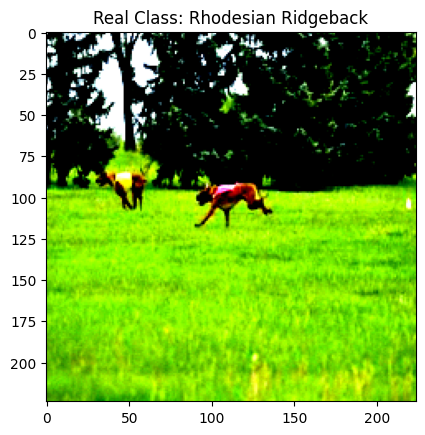

In [27]:
p = perturbed[0].cpu()
img_p = process_image(p, transpose=True, numpy=False)
plt.title(f'Real Class: {class_names[labels[0]]}')
plt.imshow(img_p)
plt.imsave(f"./Adversarial-Images/000-00.jpg", img_p)

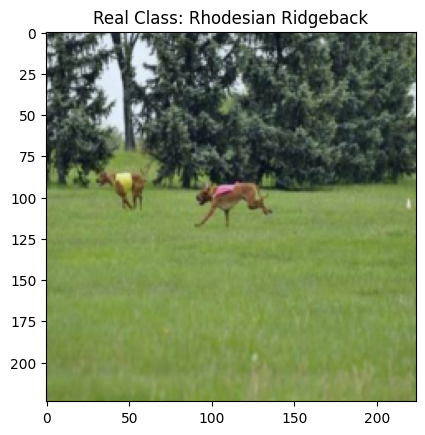

In [28]:
z = imgs[0].cpu()
img_z = process_image(z, transpose=True, numpy=False)
plt.title(f'Real Class: {class_names[labels[0]]}')
plt.imshow(img_z)

In [29]:
is_equal(img_z, img_p)

Are the images equal? False


In [30]:
uap = torch.load('./SGA/UAP/SGA/Delta_5000_20_Epochs_8_Batch.pth')

In [31]:
uap

tensor([[[-1.5686e-02,  3.9216e-02,  7.8431e-03,  ..., -1.9608e-02,
           1.1765e-02, -2.3529e-02],
         [ 1.1765e-02,  1.1765e-02,  1.5686e-02,  ...,  1.1765e-02,
           3.1373e-02, -3.1373e-02],
         [-3.1373e-02,  3.5294e-02,  1.9608e-02,  ...,  3.9216e-03,
          -3.9216e-02, -3.9216e-02],
         ...,
         [ 1.1765e-02,  1.5686e-02, -3.9216e-02,  ...,  3.1373e-02,
           1.9608e-02,  1.9608e-02],
         [-1.9608e-02, -3.9216e-03, -3.9216e-02,  ..., -3.9216e-02,
           7.8431e-03,  7.8431e-03],
         [ 3.9216e-02, -3.1373e-02, -3.9216e-02,  ...,  2.7940e-09,
          -2.3529e-02, -3.5294e-02]],

        [[ 3.9216e-02,  3.9216e-02,  3.9216e-02,  ..., -1.5686e-02,
           3.1373e-02,  2.7451e-02],
         [ 3.9216e-02,  2.7451e-02,  3.5294e-02,  ..., -1.1765e-02,
           3.5294e-02,  2.7940e-09],
         [-7.8431e-03,  3.9216e-02, -3.5294e-02,  ...,  1.1765e-02,
          -3.5294e-02,  1.9608e-02],
         ...,
         [-2.3529e-02, -3

In [32]:
uap_repeated = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1]).to(device)

In [33]:
uap_repeated

tensor([[[[-1.5686e-02,  3.9216e-02,  7.8431e-03,  ..., -1.9608e-02,
            1.1765e-02, -2.3529e-02],
          [ 1.1765e-02,  1.1765e-02,  1.5686e-02,  ...,  1.1765e-02,
            3.1373e-02, -3.1373e-02],
          [-3.1373e-02,  3.5294e-02,  1.9608e-02,  ...,  3.9216e-03,
           -3.9216e-02, -3.9216e-02],
          ...,
          [ 1.1765e-02,  1.5686e-02, -3.9216e-02,  ...,  3.1373e-02,
            1.9608e-02,  1.9608e-02],
          [-1.9608e-02, -3.9216e-03, -3.9216e-02,  ..., -3.9216e-02,
            7.8431e-03,  7.8431e-03],
          [ 3.9216e-02, -3.1373e-02, -3.9216e-02,  ...,  2.7940e-09,
           -2.3529e-02, -3.5294e-02]],

         [[ 3.9216e-02,  3.9216e-02,  3.9216e-02,  ..., -1.5686e-02,
            3.1373e-02,  2.7451e-02],
          [ 3.9216e-02,  2.7451e-02,  3.5294e-02,  ..., -1.1765e-02,
            3.5294e-02,  2.7940e-09],
          [-7.8431e-03,  3.9216e-02, -3.5294e-02,  ...,  1.1765e-02,
           -3.5294e-02,  1.9608e-02],
          ...,
     

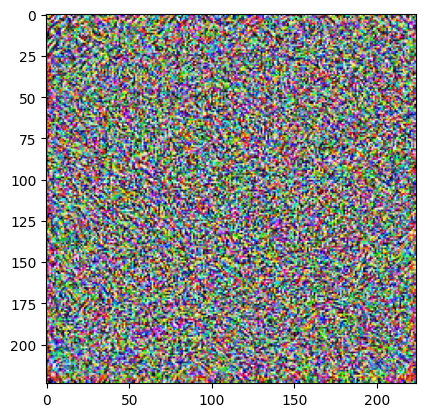

In [34]:
uap_processed = process_image(uap, transpose=True, numpy=False)
plt.imshow(uap_processed)

---

In [ ]:
num_images = 3000

In [ ]:
model.eval()

uap = torch.load('./SGA/UAP/SGA/Delta_5000_20_Epochs_8_Batch.pth')
uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1]).to(device)

probs, labels, y_out = [], [], []

with torch.no_grad():
    for i, data in enumerate(loader_val):
        x_val = data[0].to(device)
        y_val = data[1].to(device)

        y_ori = torch.nn.functional.softmax(model(x_val), dim = 1)
        perturbed = torch.clamp((x_val + uap), 0, 1) # Clamp to [0, 1]
        out = torch.nn.functional.softmax(model(perturbed), dim = 1)

        probs.append(out.cpu().numpy())
        labels.append(y_val.cpu())
        y_out.append(y_ori.cpu().numpy())

In [ ]:
# Convert batches to single numpy arrays
probs = np.array([p for l in probs for p in l])
labels = np.array([t for l in labels for t in l])
y_out = np.array([s for l in y_out for s in l])

In [ ]:
# Predictions of all the validation dataset
probs[0].argmax()

In [ ]:
probs_argmax_array = []
for i in enumerate(probs):
    probs_argmax_array.append(probs[i[0]].argmax())

In [ ]:
probs_argmax_array[5]

In [ ]:
# Real labels of all the validation dataset
labels[5]

In [ ]:
equal = 0
for i in range(num_images):
    if probs_argmax_array[i] == labels[i]:
        equal += 1

In [ ]:
fooling_rate = (equal*100)/num_images
fooling_rate

In [ ]:
top = np.argpartition(-probs, 9, axis=1)[:,:9]
top_probs = probs[np.arange(probs.shape[0])[:, None], top].astype(np.float32)

In [ ]:
top

In [ ]:
outputs = top[range(len(top)), np.argmax(top_probs, axis = 1)]

In [ ]:
y_top = np.argpartition(-y_out, 9, axis=1)[:, :9]
y_top_probs = y_out[np.arange(y_out.shape[0])[:, None], y_top].astype(np.float32)
y_outputs = y_top[range(len(y_top)), np.argmax(y_top_probs, axis=1)]

In [ ]:
print('[INFO] Fooling ratio:', (1-sum(y_outputs == outputs) / len(labels))*100)

---

In [ ]:
perturbed

In [ ]:
for i in range(len(out)):
    print(out[i].argmax())

In [ ]:
for i in range(len(y_ori)):
    print(y_ori[i].argmax())

---

In [35]:
p = torch.load('./SGA/UAP/SGA/Perturbed.pt', map_location=lambda storage, loc: storage.cuda(0))

In [36]:
len(p)*batch_size

3000

In [ ]:
p_example = p[0][2].cpu()

In [ ]:
p_img = process_image(p_example, transpose=True, numpy=False)
plt.title(f'Real Class: {class_names[labels[0]]}')
plt.imshow(p_img)

In [43]:
for i in range(len(p[0])):
    p_cpu = p[0][i].cpu()
    p_img = process_image(p_cpu, transpose=True, numpy=False)
    name = f"{i:03}.jpg"
    plt.imsave(f"./Adversarial-Images/{name}", p_img)
    print(f"[SAVED] Adversarial Image: {i:03}")

[SAVED] Adversarial Image: 000
[SAVED] Adversarial Image: 001
[SAVED] Adversarial Image: 002
[SAVED] Adversarial Image: 003
[SAVED] Adversarial Image: 004
[SAVED] Adversarial Image: 005
[SAVED] Adversarial Image: 006
[SAVED] Adversarial Image: 007


In [ ]:
p_example

In [ ]:
rng = np.random.default_rng(19680801)

N_points = 100000
n_bins = 20

# Generate two normal distributions
dist1 = rng.standard_normal(N_points)
dist2 = 0.4 * rng.standard_normal(N_points) + 5

fig, axs = plt.subplots(3, 1, figsize=(5, 15), sharex=True, sharey=True,
                        tight_layout=True)

# We can increase the number of bins on each axis
axs[0].hist2d(dist1, dist2, bins=40)

# As well as define normalization of the colors
axs[1].hist2d(dist1, dist2, bins=40, norm=colors.LogNorm())

# We can also define custom numbers of bins for each axis
axs[2].hist2d(dist1, dist2, bins=(80, 10), norm=colors.LogNorm())

plt.show()